# Model Training and Processing

In [1]:
import tensorflow as tf

In [2]:
train_data_directory = r'C:\Users\imadc\Super Folder\PrepareData\train'
test_data_directory =  r'C:\Users\imadc\Super Folder\PrepareData\test'
validation_data_directory = r'C:\Users\imadc\Super Folder\PrepareData\train'

target_size = (80, 80)
batchsize = 8
cm = 'categorical'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
    rescale=1.0/255.0,  
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2,  
    horizontal_flip=True,  
    vertical_flip=False,  
    fill_mode='nearest' ,
    validation_split=0.2)


train_data = train_data_generator.flow_from_directory(train_data_directory,
                                              target_size= target_size, 
                                              batch_size=batchsize,
                                              class_mode= cm,
                                              shuffle= True,
                                              subset = 'training')

validation_data = train_data_generator.flow_from_directory(validation_data_directory,
                                              target_size=target_size, 
                                              shuffle= True,
                                              batch_size=batchsize,
                                              class_mode=cm,
                                              subset='validation')

Found 128 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [4]:
test_data_generator = ImageDataGenerator(rescale= 1./255)
test_data = test_data_generator.flow_from_directory(test_data_directory,
                                              target_size=target_size, 
                                              batch_size=batchsize,
                                              class_mode= cm
                                              )

Found 40 images belonging to 2 classes.


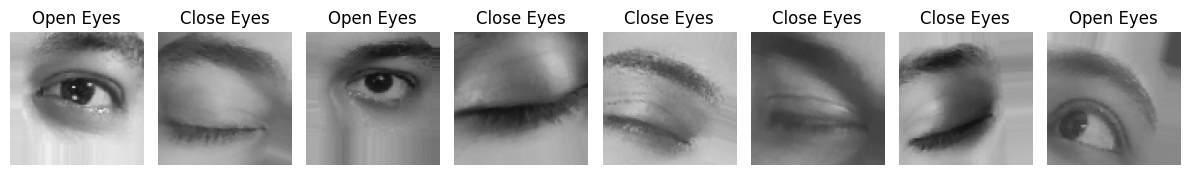

In [6]:
import matplotlib.pyplot as plt

class_labels = {0: 'Close Eyes', 1: 'Open Eyes'}  

images, one_hot_labels = next(train_data)
labels = [class_labels[idx] for idx in one_hot_labels.argmax(axis=1)]

num_images = min(batchsize, 10)
plt.figure(figsize=(12, 5))

for i in range(num_images):
    plt.subplot(2, 8, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input , Flatten , Dense , MaxPooling2D
from tensorflow.keras.optimizers import Adam

#InceptionV3 pretrained model, just using its learning not its 1000 classes
base_model = MobileNet(include_top=False,
                         weights='imagenet',
                         input_tensor=Input(shape=(80, 80, 3)))

base_output = base_model.output
#base_output.summary()
flattened_output = Flatten()(base_output)

#fully connected layer with 64 neurons
dense_layer = Dense(64, activation='relu')(flattened_output)

#dropout layer to reduce overfitting
dropout_layer = Dropout(0.5)(dense_layer)

#final output layer with 2 neurons beacuse we have 2 classes
output_layer = Dense(2, activation='sigmoid')(dropout_layer)

#custom model specifying the input and output layers
custom_model = Model(inputs=base_model.input, outputs=output_layer)

# Freezeweights of base model 
for layer in base_model.layers:
    layer.trainable = False

In [7]:
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 40, 40, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 40, 40, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 40, 40, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 40, 40, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 40, 40, 32)        128   

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [9]:
#Path to save your model
model_path = r'C:\Users\imadc\Super Folder\modelss\MobileNet.h5'

In [10]:
#Callbacks and conditions for stopping the epochs and specific runs and storing the best values in the model

val_accuracy_monitor = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, patience=5, verbose = 3) 

accuracy_monitor = ModelCheckpoint(model_path, monitor='accuracy', save_best_only=True , patience = 5 ,verbose=3)

val_loss_monitor = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True , patience = 5 , verbose=3)

earlystopping_condition = EarlyStopping(monitor= 'val_loss' , patience=5 , restore_best_weights=True , verbose = 3)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience = 5 , verboes = 3)


training_monitors = [val_accuracy_monitor, accuracy_monitor , val_loss_monitor, earlystopping_condition, learning_rate]

In [11]:
train_steps_per_epoch = len(train_data)
val_steps_per_epoch = len(validation_data)

print("Number of training steps per epoch:", train_steps_per_epoch)
print("Number of validation steps per epoch:", val_steps_per_epoch)


Number of training steps per epoch: 16
Number of validation steps per epoch: 4


In [12]:
epochs = 25

In [13]:
custom_model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [14]:
hist = custom_model.fit(train_data,
                           steps_per_epoch=train_steps_per_epoch,
                           epochs=epochs,
                           validation_data=validation_data,
                           validation_steps=val_steps_per_epoch,
                           callbacks=training_monitors)

Epoch 1/25
15/16 [===========================>..] - ETA: 0s - loss: 0.2850 - accuracy: 0.9000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to C:\Users\imadc\Super Folder\modelss\MobileNet.h5

Epoch 1: accuracy improved from -inf to 0.90625, saving model to C:\Users\imadc\Super Folder\modelss\MobileNet.h5


C:\Users\imadc\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_loss improved from inf to 0.00798, saving model to C:\Users\imadc\Super Folder\modelss\MobileNet.h5
16/16 [==============================] - 4s 126ms/step - loss: 0.2672 - accuracy: 0.9062 - val_loss: 0.0080 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/25
15/16 [===========================>..] - ETA: 0s - loss: 0.0647 - accuracy: 0.9833
Epoch 2: val_accuracy did not improve from 1.00000

Epoch 2: accuracy improved from 0.90625 to 0.98438, saving model to C:\Users\imadc\Super Folder\modelss\MobileNet.h5

Epoch 2: val_loss improved from 0.00798 to 0.00016, saving model to C:\Users\imadc\Super Folder\modelss\MobileNet.h5
16/16 [==============================] - 1s 68ms/step - loss: 0.0606 - accuracy: 0.9844 - val_loss: 1.5912e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/25
15/16 [===========================>..] - ETA: 0s - loss: 0.0590 - accuracy: 0.9833
Epoch 3: val_accuracy did not improve from 1.00000

Epoch 3: accuracy did not improve from 0.98438

Epoch 3: val_loss im

In [15]:
training_loss = hist.history['loss']
training_accuracy = hist.history['accuracy']

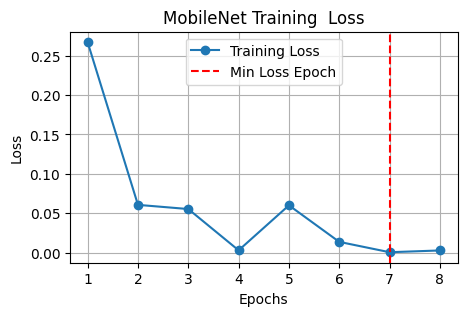

In [17]:
import matplotlib.pyplot as plt

num_epochs_completed = len(training_loss)
min_val_loss_epoch = training_loss.index(min(training_loss)) + 1 

plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs_completed + 1), training_loss, label='Training Loss', marker='o')
plt.axvline(x=min_val_loss_epoch, color='r', linestyle='--', label='Min Loss Epoch')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNet Training  Loss')
plt.legend()
plt.grid(True)
plt.show()

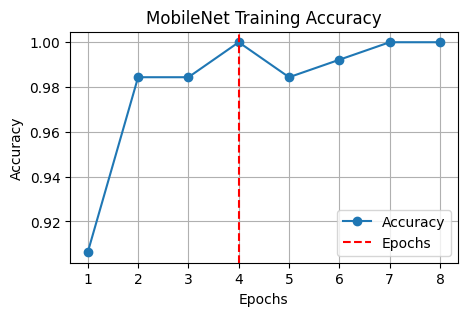

In [24]:
max_val_accuracy_epoch = training_accuracy.index(max(training_accuracy)) + 1  

plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs_completed + 1), training_accuracy, label='Accuracy', marker='o')
plt.axvline(x=max_val_accuracy_epoch, color='r', linestyle='--', label='Epochs')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

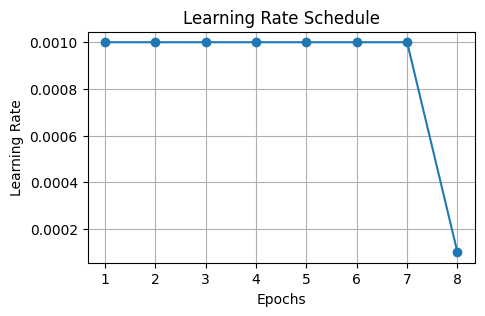

In [25]:
learning_rates = hist.history['lr']

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(learning_rates) + 1), learning_rates, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()